# Generation as post-analysis in aids dataset

In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [3]:
%matplotlib inline

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

### Experiment setting - links to data

In [4]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

## Statistical analysis with original data

In [5]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,1,1,1,0,100,169.0,39.0,34
1,287,0,1,2,2,0,90,149.5,15.0,34
2,199,0,1,1,1,0,90,46.0,53.0,48
3,270,0,1,1,2,0,100,54.5,6.0,51
4,276,0,1,1,1,0,100,95.0,7.0,34


In [6]:
aids_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')

In [7]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]

In [8]:
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
aids_control_columns

['time',
 'censor',
 'strat2',
 'sex',
 'raceth',
 'ivdrug',
 'karnof',
 'cd4',
 'priorzdv',
 'age']

In [9]:
np.quantile(aids_control[aids_control['censor']==1]['time'],0.95)

233.0

### Data loading and Feature analysis treated/control

In [10]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [11]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [12]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [13]:
df_transformed_all.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age', 'treatment'],
      dtype='object')

In [14]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,189.0,0.0,1.0,0.0,0.0,0.0,3.0,169.0,39.0,34.0,0
1,287.0,0.0,1.0,1.0,1.0,0.0,2.0,149.5,15.0,34.0,0
2,199.0,0.0,1.0,0.0,0.0,0.0,2.0,46.0,53.0,48.0,0
3,270.0,0.0,1.0,0.0,1.0,0.0,3.0,54.5,6.0,51.0,0
4,276.0,0.0,1.0,0.0,0.0,0.0,3.0,95.0,7.0,34.0,0


In [15]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 10


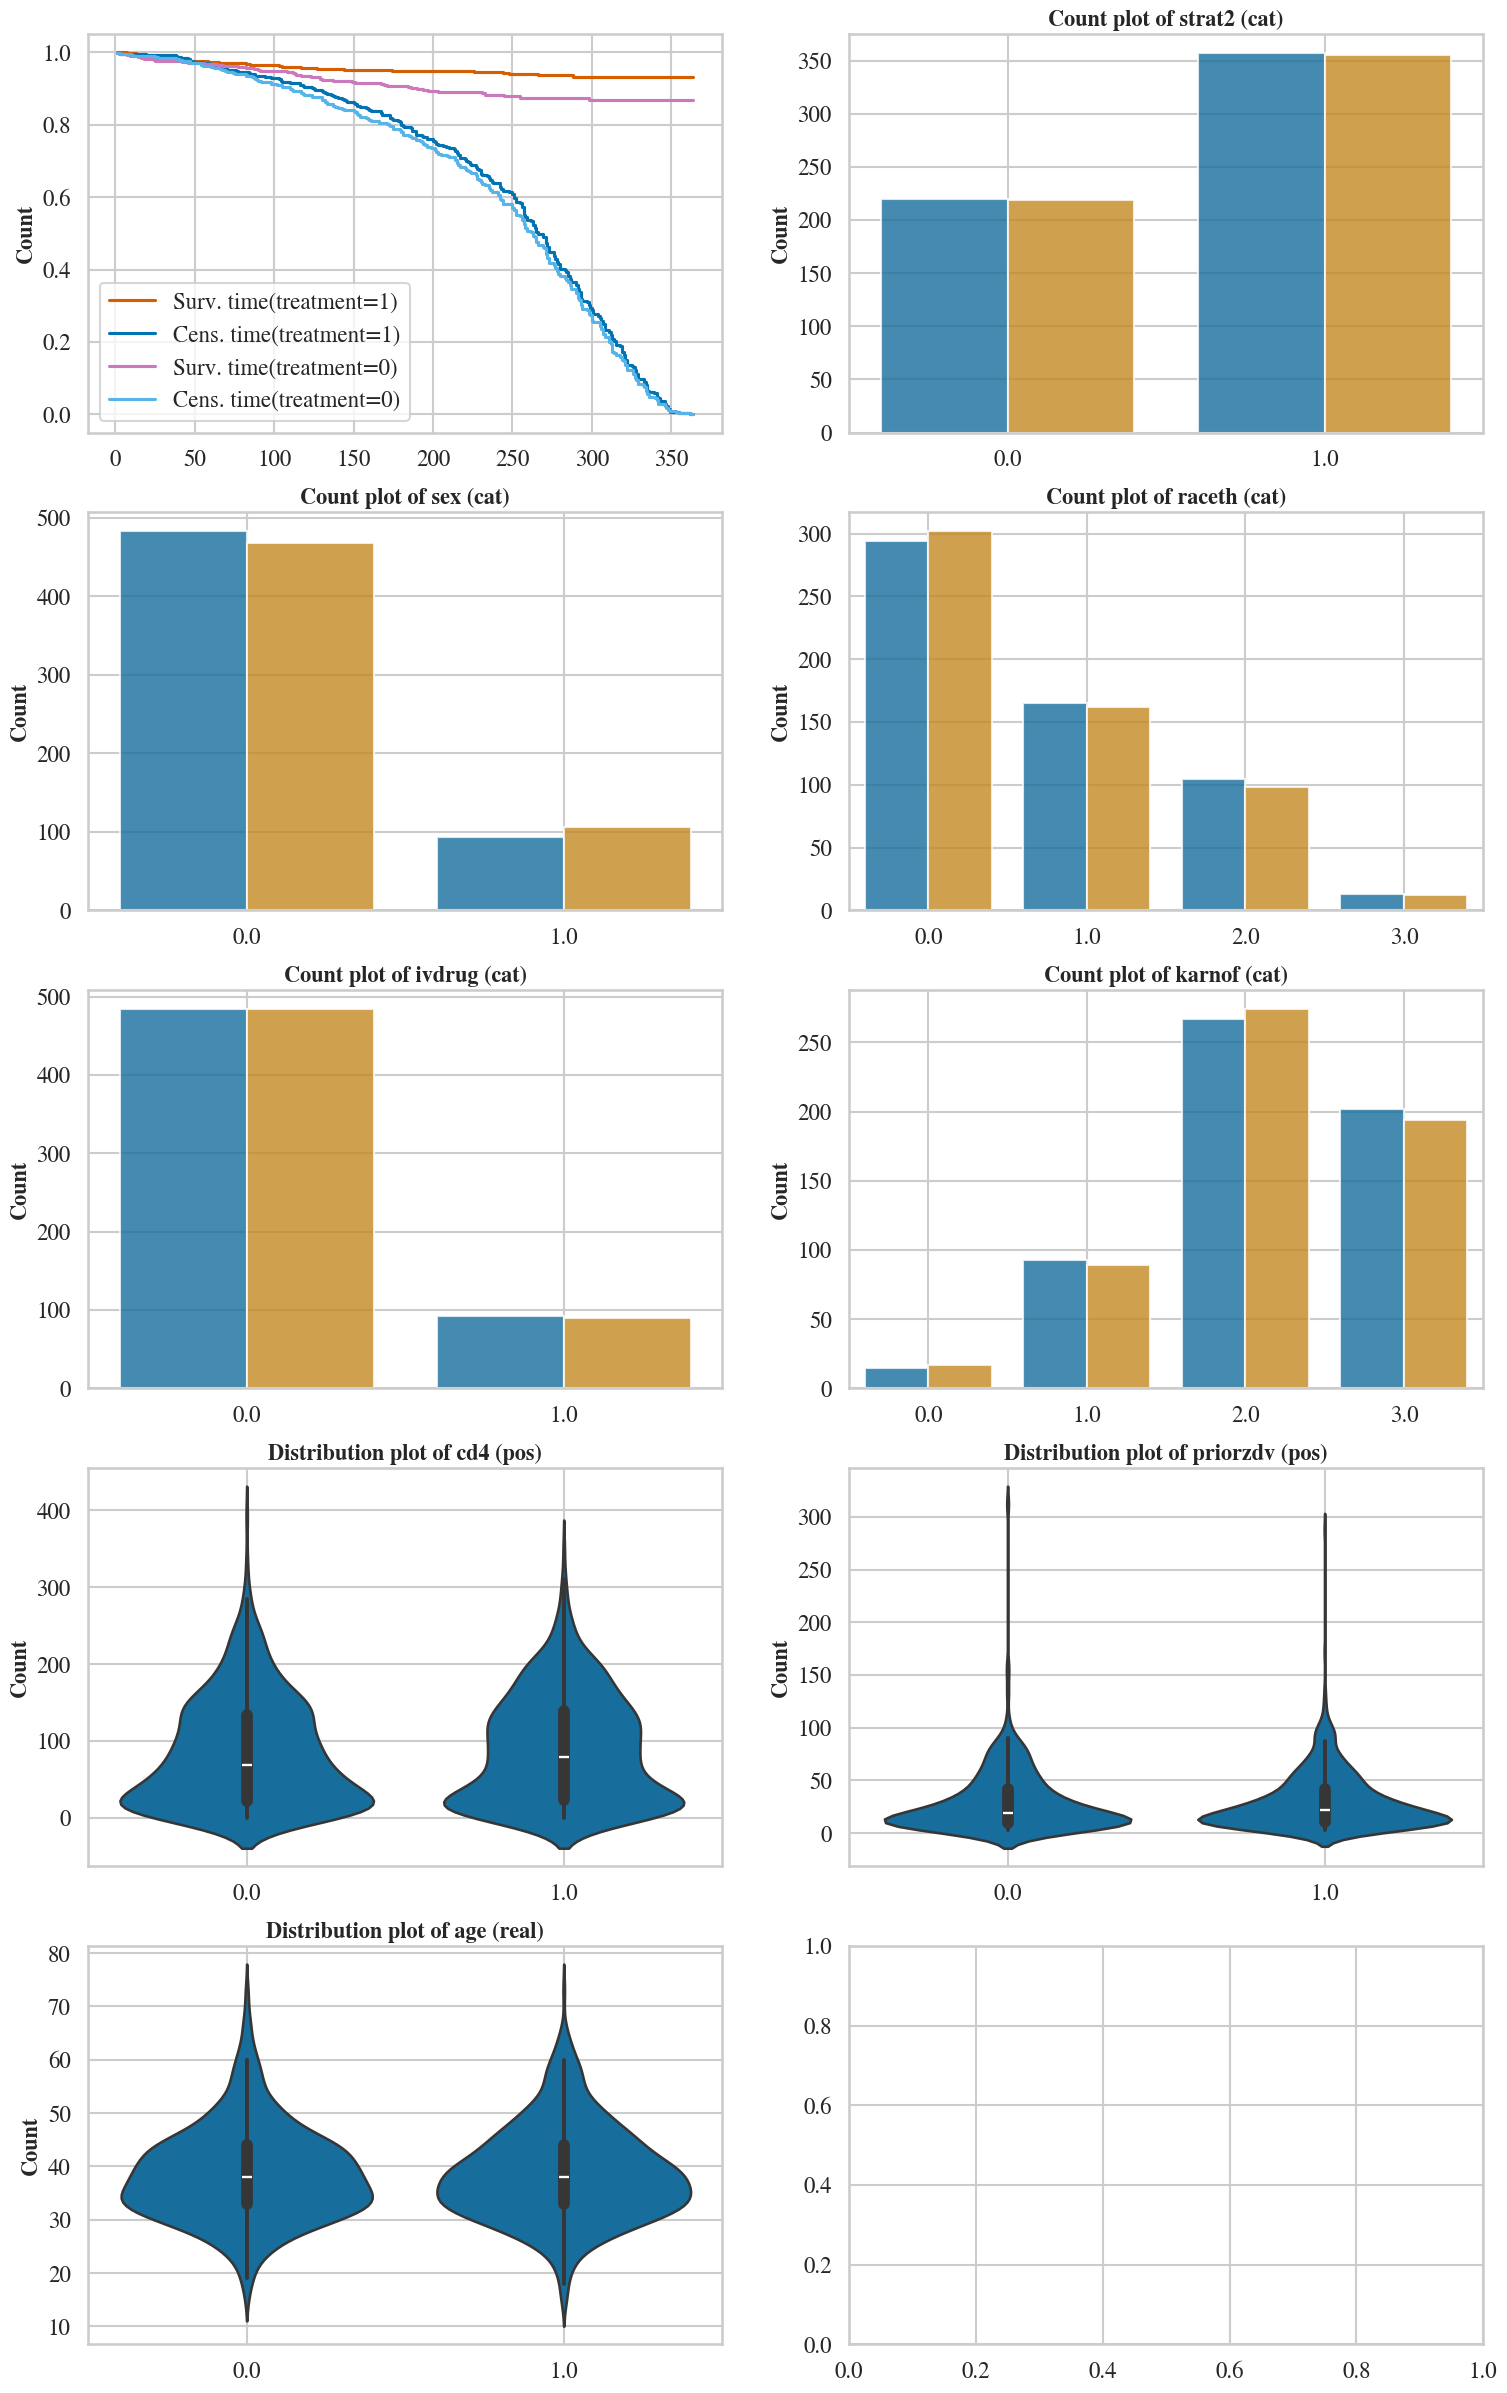

In [16]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [17]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [18]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

### Experiment setting

In [19]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [20]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 10
epochs = 500
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [21]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_loglog', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.0726, ELBO_train: -22.11004639, KL_z: 1.86178567, KL_s: 0.05119915, reconstruction loss: -20.19706156
Epoch: [100]  time: 2.8874, ELBO_train: -17.69480629, KL_z: 0.72614286, KL_s: 0.05891428, reconstruction loss: -16.90974915
Epoch: [200]  time: 5.7284, ELBO_train: -17.52016029, KL_z: 0.88170586, KL_s: 0.05695724, reconstruction loss: -16.58149719
Epoch: [300]  time: 8.5561, ELBO_train: -17.43394928, KL_z: 0.96356694, KL_s: 0.05085731, reconstruction loss: -16.41952504
Epoch: [400]  time: 11.4053, ELBO_train: -17.47002945, KL_z: 1.11889963, KL_s: 0.05455971, reconstruction loss: -16.29657011
Training finished.


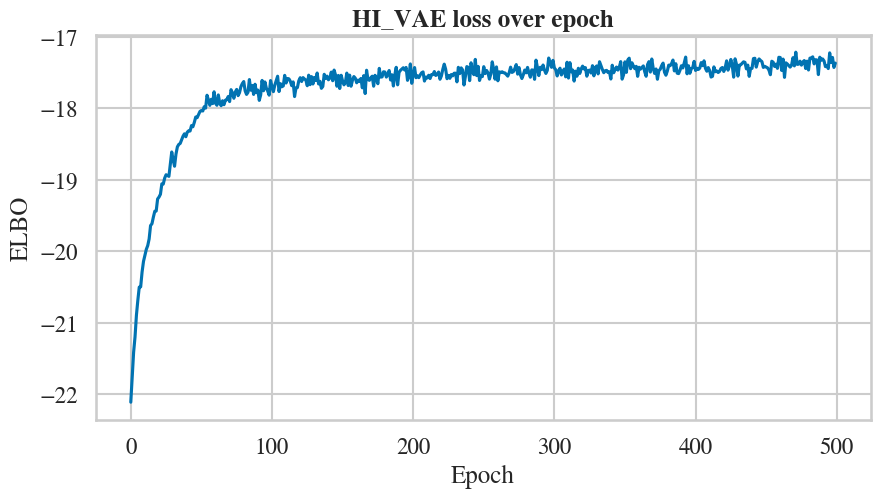

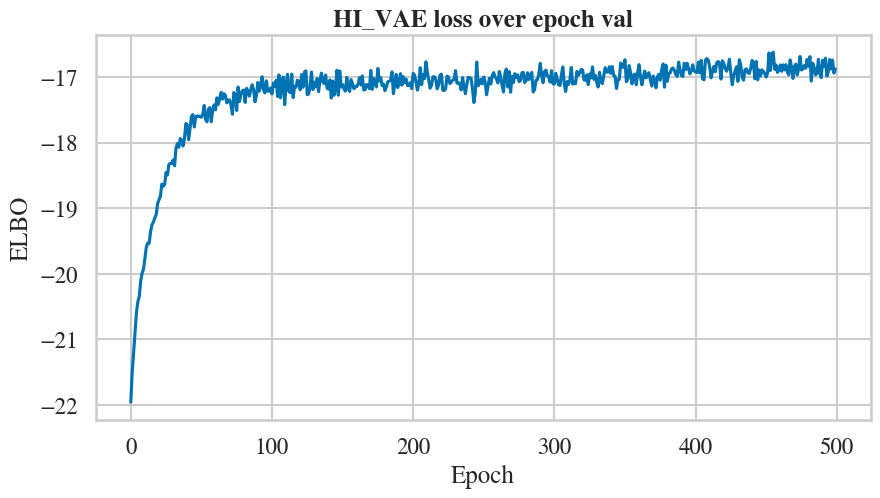

In [22]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [23]:
#visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
#                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

### Visualize the generated samples

In [24]:
data.shape

torch.Size([577, 19])

### Statistical analysis with simulated data

In [25]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [26]:
miss_mask_forgen.shape

torch.Size([577, 9])

In [27]:
data_forgen.shape

torch.Size([577, 19])

#### Generate from original sample

In [28]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

577


In [29]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [30]:
df_transformed_generated

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,sample
0,326.830719,0.0,0.0,0.0,2.0,0.0,2.0,118.054092,13.440523,35.348648,0
1,294.319855,0.0,1.0,1.0,1.0,0.0,3.0,34.472054,16.885136,26.948669,0
2,194.233261,0.0,1.0,0.0,1.0,0.0,3.0,72.951057,25.098476,36.391636,0
3,242.819702,0.0,1.0,0.0,1.0,0.0,2.0,27.391634,5.349423,39.904263,0
4,273.168335,0.0,1.0,1.0,0.0,0.0,1.0,64.994156,9.885752,34.454529,0
...,...,...,...,...,...,...,...,...,...,...,...
572,171.089996,0.0,1.0,1.0,0.0,0.0,3.0,142.512711,4.054728,23.391048,0
573,282.887421,0.0,0.0,1.0,2.0,0.0,2.0,7.636080,10.773791,25.573065,0
574,220.311111,0.0,0.0,0.0,1.0,0.0,2.0,9.470022,13.078197,25.357782,0
575,247.357712,0.0,1.0,0.0,0.0,0.0,3.0,55.583725,8.405091,41.759487,0


comparison variable sample 10


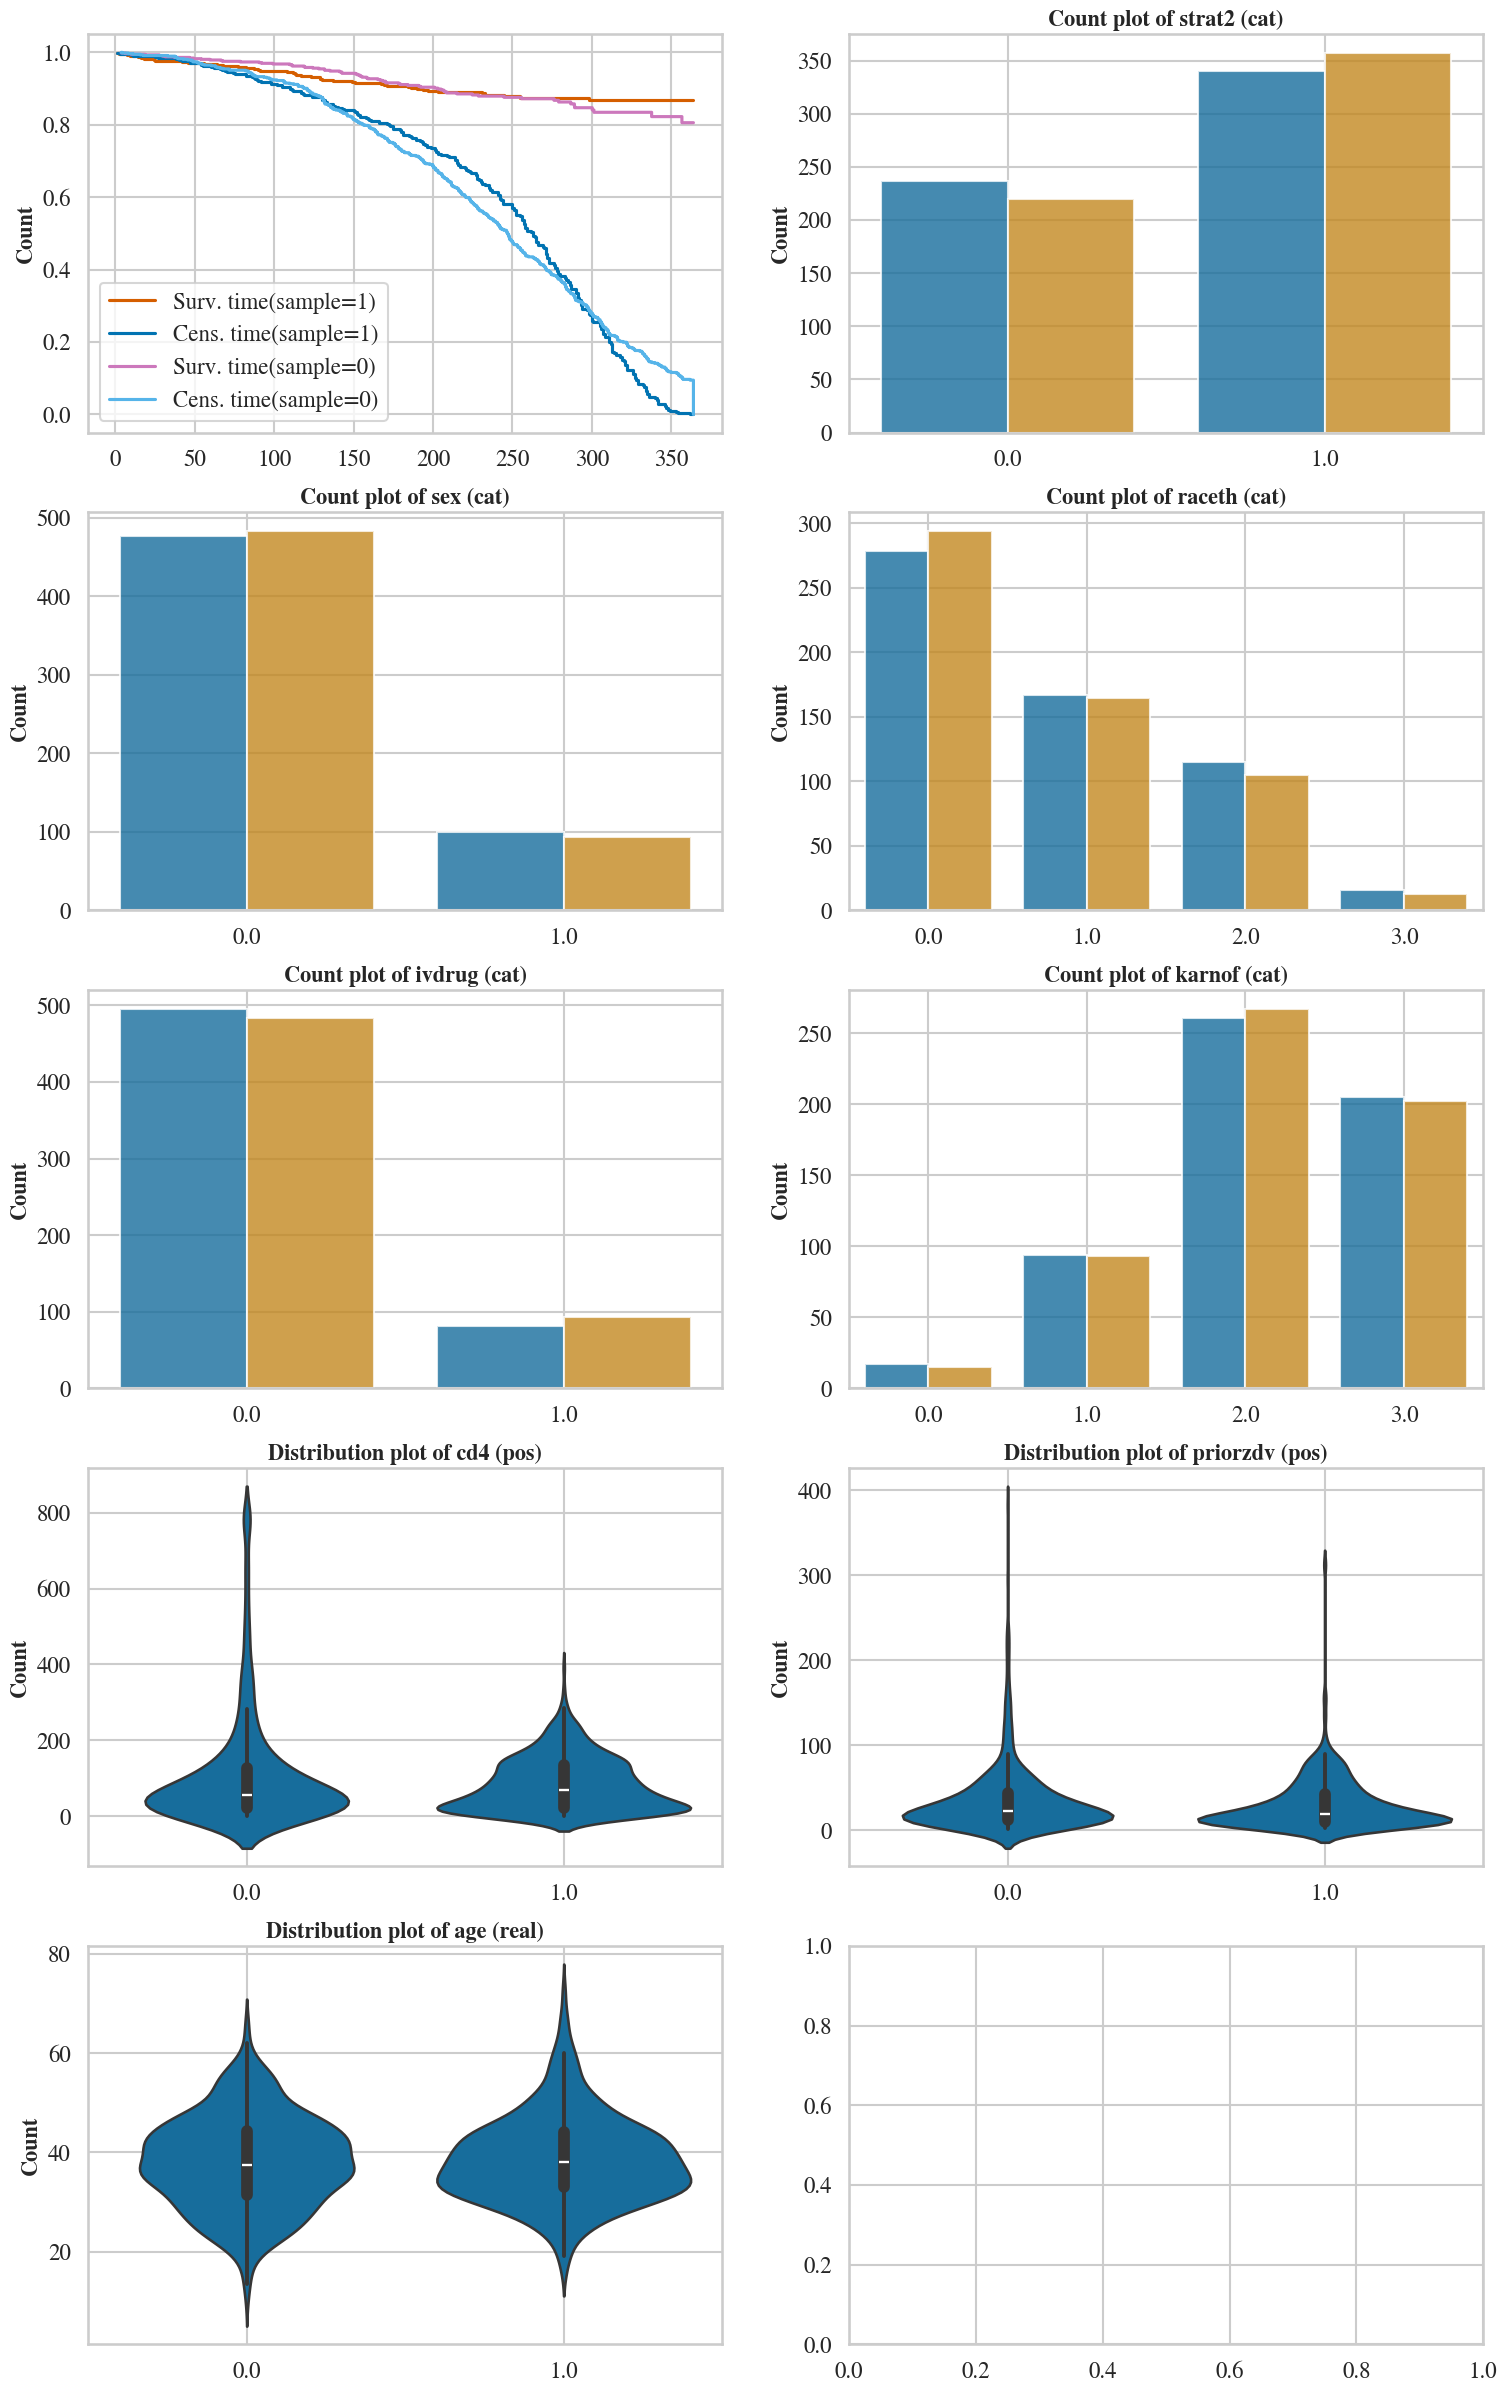

In [31]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [32]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [33]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                              1154                  577                  577        
time, median [Q1,Q3]                         0  241.0 [155.6,297.9]  228.6 [155.3,297.6]  251.0 [158.0,298.0]   0.611
censor, n (%)            0.0                            1023 (88.6)           509 (88.2)           514 (89.1)   0.711
                         1.0                             131 (11.4)            68 (11.8)            63 (10.9)        
strat2, n (%)            0.0                             457 (39.6)           237 (41.1)           220 (38.1)   0.336
                         1.0                             697 (60.4)           340 (58.9)           357 (61.9)        
sex, n (%)               0.0                            

In [34]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=aids_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [35]:
#df_transformed_all.head()

In [36]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  257.0 [174.0,300.0]  251.0 [158.0,298.0]  263.0 [187.0,305.0]   0.014
censor, n (%)            0.0                               1055 (91.7)           514 (89.1)           541 (94.3)   0.002
                         1.0                                  96 (8.3)            63 (10.9)             33 (5.7)        
strat2, n (%)            0.0                                439 (38.1)           220 (38.1)           219 (38.2)   1.000
                         1.0                                712 (61.9)           357 (61.9)           355 (61.8)        
sex, n (%)               0.0    

In [37]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  250.5 [174.1,301.6]  233.0 [165.3,298.8]  263.0 [187.0,305.0]   0.013
censor, n (%)            0.0                               1058 (91.9)           517 (89.6)           541 (94.3)   0.005
                         1.0                                  93 (8.1)            60 (10.4)             33 (5.7)        
strat2, n (%)            0.0                                447 (38.8)           228 (39.5)           219 (38.2)   0.679
                         1.0                                704 (61.2)           349 (60.5)           355 (61.8)        
sex, n (%)               0.0    

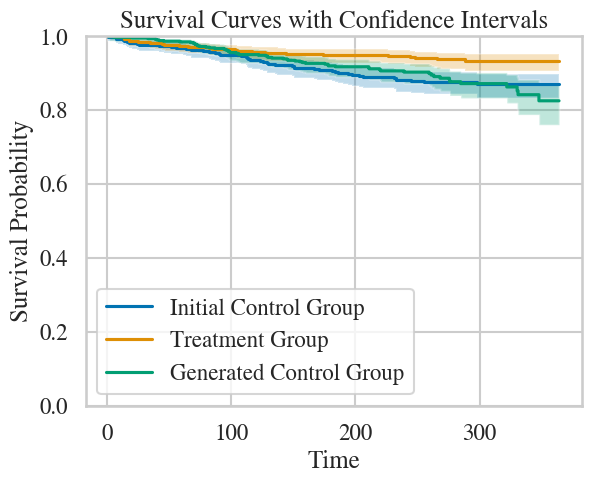

In [38]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

In [39]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']

    

In [45]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)

In [66]:
df_transformed_all_oh.columns


Index(['time', 'censor', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

In [67]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-1.51111787e-02,  2.03117243e-01, -5.55172796e-01, -1.46215358e-02,
       -7.93512048e-04,  2.40314802e-02, -6.66311702e-01, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

In [69]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,6])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]
   

0
1
2
3
4
5
6
7
8
9


In [70]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

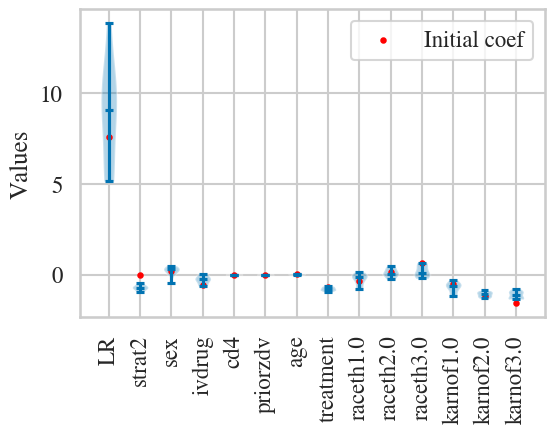

In [71]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,-1])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

### Log rank test

In [72]:
coef_treat[:,0]

array([ 5.52663345,  8.39757288,  5.48634255,  8.4295364 ,  9.70508824,
       11.00303706, 10.63237714, 13.84957025,  9.90864105,  5.15119989])

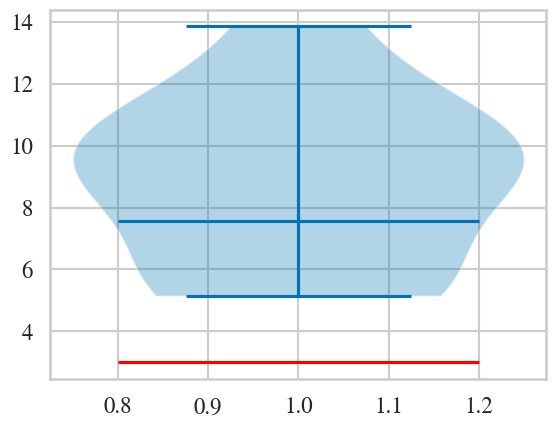

In [77]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2)
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### test coefficient traitement (Cox)

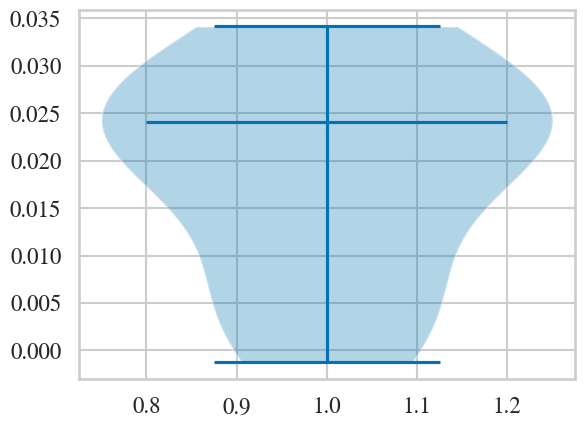

In [60]:
plt.violinplot(coef_treat[:,6])#,
plt.hlines(y_values[6],0.8,1.2)